## CNN-LSTM for Sequence Prediction
Implemented a CNN-LSTM model and training loop with Pytorch to recognize patterns from sequences of raw images of digits (MNIST dataset) and predict the future digits. The training sequences are generated by varying shifts. For instance, the input and target of the CNN-LSTM model can be the image squence whose categories are shown as below:
            Input: 1,3,5,7,9,1   Target: 3,5,7  (shifted by 2)
            Input: 2,6,0,4,8,2   Target: 6,0,4  (shifted by 4)
where the input and target consists of 5 elements and 3 elements, respectively.

In [11]:
# The arguments of the experiment
class Args:
    def __init__(self):
        # Based on the availablity of GPU, decide whether to run the experiment on cuda or cpu.
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # The random seed for the exp.
        self.seed = 1
        # The mini batch size of training and testing data. If you find you machines run very slow
        # or experinece with OOM issue, you can set a smaller batch size
        self.batch_size = 50
        # The epochs of the exps. The referenced model achieve over 95% test accuracy after 1 epoch.
        self.epochs = 1
        # The learning rate of the SGD optimizer
        self.lr = 0.1
        # The momentum of SGD optimizer
        self.momentum = 0.5
        # how many iterations to display the training stats
        self.log_interval = 10
        # The height of input image
        self.img_h = 28
        # The width of the input image
        self.img_w = 28
        # The length of input sequence
        self.input_seq_len = 5
        # The lenght of the sequence to predict
        self.target_seq_len = 2
        # The list to sample shift to generate the training sequence.
        self.train_shift_list = [1,2,4,5]
        # The list to sample shift to generate the testing sequence.
        self.test_shift_list = [1,2,3,4,5]

In [12]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
args = Args()
torch.manual_seed(args.seed)

In [13]:
"""
Generate training and testing sequence
"""

class MNIST_SEQ_DATASET(Dataset):
    def __init__(self, csv_path, height, width, input_len, output_len, seq_shift, transform=None):
        """
        Custom dataset example for reading data from csv

        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.input_len = input_len
        self.output_len = output_len
        self.transform = transform
        self.seq_shift = seq_shift
        unique_label_array = np.unique(self.labels)
        self.label_data_id_dict = {}
        for unique_label in unique_label_array:
            self.label_data_id_dict[unique_label] = np.where(self.labels == unique_label)[0]

    def get_single_image(self, index):
        single_image_label = self.labels[index]
        # Read each 784 pixels and reshape the 1D array ([784]) to 2D array ([28,28])
        img_as_np = np.asarray(self.data.iloc[index][1:]).reshape(28, 28).astype('uint8')
        # Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __getitem__(self, index):
        # Randomly sample the shift from predefined shift list
        seq_shift = np.random.choice(self.seq_shift)
        # Randomly select one category as leading digit
        start_idx = np.random.choice(10)
        # The sequence with following digits
        seq_digit = np.arange(start_idx, start_idx + seq_shift * (self.input_len + self.output_len), seq_shift)
        # Modulo opeartion over the digit sequence
        seq_digit = seq_digit % 10
        img_seq = []
        label_seq = []
        # Collect the images for each digit
        for digit in seq_digit:
            data_id = np.random.choice(self.label_data_id_dict[digit])
            img, label = self.get_single_image(data_id)
            img_seq.append(img)
            label_seq.append(label)
        # Return image and the label
        input_img_seq = img_seq[:self.input_len]
        input_label_seq = label_seq[:self.input_len]
        target_img_seq = img_seq[self.input_len:]
        target_label_seq = label_seq[self.input_len:]
        return torch.stack(input_img_seq), torch.stack(target_img_seq), \
                torch.from_numpy(np.stack(input_label_seq)), \
                torch.from_numpy(np.stack(target_label_seq)), \
                seq_shift

    def __len__(self):
        return len(self.data.index)

In [14]:
"""
Instantiate the training and testing datasets
"""
transformations = transforms.Compose([transforms.ToTensor()])
mnist_train = \
    MNIST_SEQ_DATASET('./mnist_train.csv',
                             args.img_h, args.img_w, args.input_seq_len, args.target_seq_len,
                             args.test_shift_list,
                             transformations)

mnist_test = \
    MNIST_SEQ_DATASET('./mnist_test.csv',
                             args.img_h, args.img_w, args.input_seq_len, args.target_seq_len,
                             args.test_shift_list,
                             transformations)

mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                                    batch_size=args.batch_size,
                                                    shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                                    batch_size=args.batch_size,
                                                    shuffle=False)

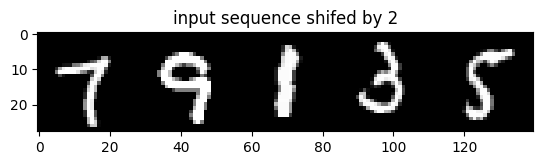

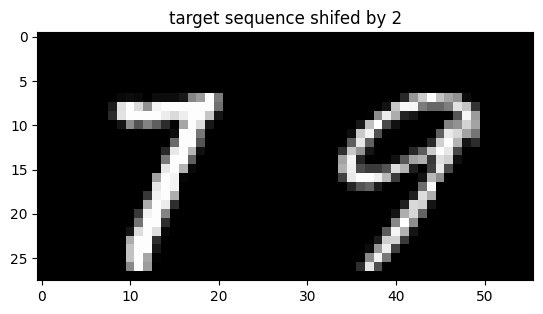

In [26]:
"""
Visualize the input sequence and target sequence
"""
input_img_seq, target_img_seq, input_label_seq, target_label_seq, seq_shift = mnist_train[0]
img_to_disp = input_img_seq.permute(1,2,0,3).reshape(args.img_h,-1,args.img_w)
input_img_seq = img_to_disp.reshape(args.img_h, -1)
img_to_disp = target_img_seq.permute(1,2,0,3).reshape(args.img_h,-1,args.img_w)
target_img_seq = img_to_disp.reshape(args.img_h, -1)
plt.imshow(input_img_seq,  cmap="gray")
plt.title('input sequence shifed by {}'.format(seq_shift))
plt.show()
plt.imshow(target_img_seq, cmap="gray")
plt.title('target sequence shifed by {}'.format(seq_shift))
plt.show()

In [30]:
""" 
CNN-LSTM Model
"""
class CNN(nn.Module):
    """Custom CNN model to extract visual features from input image"""

    def __init__(self):
        """ Define and instantiate your layers"""
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128)
        )


    def forward(self, x):
        """
        Run forward pass on input image X

        Args:
            x: torch tensor of input image,
                with shape of [batch_size, 1, img_h, img_w]

        Return:
            out: torch tensor of feature vector computed on input image,
                with shape of [batch_size, latent_dim]

        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class CNN_LSTM(nn.Module):
    """ Custom CNN-LSTM model for sequence prediction problem """
    def __init__(self):
        """ Define and instantiate your layers"""
        super(CNN_LSTM, self).__init__()
        self.cnn = CNN()
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=256,
            num_layers=5,
            batch_first=True,
            dropout=0.3
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )
        self.projection = nn.Linear(256, 128)

    def forward(self, x, num_step_to_predict):
        """
        Run forward pass on image squence x and predict the future digits

        Args:
            x : torch tensor of input image sequence,
                    with shape of [batch_size, input_time_step, 1, img_h, img_w]
            num_step_to_predict: an interger on how many steps to predict.

        Returns:
            output: torch tensor of predicted categorical distribution
                    for the ENTIRE sequence, including input and predicted sequence,
                    with shape of [batch_size, input_time_step + num_step_to_predict, 10].
                    Noted the output from i step is the prediction for 1+1 step.

        """

        # Original shape: [batch_size, seq_len, 1, height, width]
        # Reshaped to: [batch_size * seq_len, 1, height, width]
        x_reshaped = x.view(-1, 1, x.size(3), x.size(4))
        # Process all images through CNN at once
        features = self.cnn(x_reshaped)
        # Reshape back to sequence form: [batch_size, seq_len, 128]
        features = features.view(x.size(0), x.size(1), -1)

        # Process sequence through LSTM
        # lstm_out: outputs for each time step [batch_size, seq_len, hidden_size(256)]
        # h_n: final hidden state [num_layers(2), batch_size, hidden_size(256)]
        # c_n: final cell state [num_layers(2), batch_size, hidden_size(256)]
        lstm_out, (h_n, c_n) = self.lstm(features)
        # Converts LSTM outputs to class probabilities
        # Shape: [batch_size, seq_len, num_classes(10)]
        predictions = self.decoder(lstm_out)
        # Extract last time step output
        last_output = lstm_out[:, -1:, :]
        current_hidden = (h_n, c_n)

        future_predictions = []
        for _ in range(num_step_to_predict):
            # Project the LSTM output to match input size: 256 -> 128
            projected_output = self.projection(last_output)
            # Generate next prediction
            next_output, current_hidden = self.lstm(projected_output, current_hidden)
            next_pred = self.decoder(next_output)
            future_predictions.append(next_pred)
            last_output = next_output

        # Concatenate predictions
        if future_predictions:
            # future_predictions is a list of tensors each with shape [batch_size, 1, num_classes]
            future_predictions = torch.cat(future_predictions, dim=1)
            # Shape: [batch_size, input_time_step + num_step_to_predict, 10]
            output = torch.cat([predictions, future_predictions], dim=1)
        else:
            output = predictions

        return output

In [33]:
"""
Training Loop
"""
model = CNN_LSTM()
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.85, 0.95))

def train(epoch):
    model.train()
    for batch_idx, (input_img_seq, target_img_seq, input_label_seq,
                    target_label_seq, seq_shift) in enumerate(mnist_train_loader):
        # batch_size * input_seq_len * 1 * img_h * img_w
        input_img_seq = input_img_seq.to(args.device)
        # batch_size * input_seq_len
        input_label_seq = input_label_seq.to(args.device)
        # batch_size * output_seq_len * 1 * img_h * img_w
        target_img_seq = target_img_seq.to(args.device)
        # batch_size * output_seq_len
        target_label_seq = target_label_seq.to(args.device)

        # YOUR CODE HERE
        optimizer.zero_grad()
        output = model(input_img_seq, args.target_seq_len)
        prediction = output[:, -args.target_seq_len-1:-1].reshape(-1, 10)
        target = target_label_seq.reshape(-1)
        loss = F.cross_entropy(prediction, target)
        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(input_img_seq), len(mnist_train_loader.dataset),
                100. * batch_idx / len(mnist_train_loader), loss.item()))

for epoch in range(args.epochs):
    train(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300653
Train Epoch: 0 [500/60000 (1%)]	Loss: 2.302943
Train Epoch: 0 [1000/60000 (2%)]	Loss: 2.286844
Train Epoch: 0 [1500/60000 (2%)]	Loss: 2.201420
Train Epoch: 0 [2000/60000 (3%)]	Loss: 2.189901
Train Epoch: 0 [2500/60000 (4%)]	Loss: 2.071462
Train Epoch: 0 [3000/60000 (5%)]	Loss: 1.938813
Train Epoch: 0 [3500/60000 (6%)]	Loss: 1.665869
Train Epoch: 0 [4000/60000 (7%)]	Loss: 1.797579
Train Epoch: 0 [4500/60000 (8%)]	Loss: 1.672045
Train Epoch: 0 [5000/60000 (8%)]	Loss: 1.639987
Train Epoch: 0 [5500/60000 (9%)]	Loss: 1.673016
Train Epoch: 0 [6000/60000 (10%)]	Loss: 1.639930
Train Epoch: 0 [6500/60000 (11%)]	Loss: 1.610335
Train Epoch: 0 [7000/60000 (12%)]	Loss: 1.692068
Train Epoch: 0 [7500/60000 (12%)]	Loss: 1.640564
Train Epoch: 0 [8000/60000 (13%)]	Loss: 1.572562
Train Epoch: 0 [8500/60000 (14%)]	Loss: 1.554496
Train Epoch: 0 [9000/60000 (15%)]	Loss: 1.477200
Train Epoch: 0 [9500/60000 (16%)]	Loss: 1.334461
Train Epoch: 0 [10000/60000 (17%)]	L

In [34]:
"""
Validate model on test data
"""

def test():
    model.eval()
    top1_acc_dict = {test_shift:{'sum_acc':0, 'count':0} for test_shift in args.test_shift_list}
    top5_acc_dict = {test_shift:{'sum_acc':0, 'count':0} for test_shift in args.test_shift_list}
    for batch_idx, (input_img_seq, target_img_seq, input_label_seq, target_label_seq, seq_shift) in enumerate(mnist_test_loader):
        batch_size = input_img_seq.shape[0]
        # batch_size * input_seq_len * 1 * img_h * img_w
        input_img_seq = input_img_seq.to(args.device)
        # batch_size * input_seq_len
        input_label_seq = input_label_seq.to(args.device)
        # batch_size * output_seq_len * 1 * img_h * img_w
        target_img_seq = target_img_seq.to(args.device)
        # batch_size * output_seq_len
        target_label_seq = target_label_seq.to(args.device)

        total_pred = model(input_img_seq, args.target_seq_len)
        pred = total_pred[:,:-1][:,-1 * args.target_seq_len:].reshape(-1,10)

        _, top_index = pred.topk(5, dim = -1)
        correct_pred = top_index == target_label_seq.reshape(-1)[:,None]
        top1_acc = correct_pred[:,0].float().reshape(batch_size, -1) * 100
        top5_acc = correct_pred[:,:5].sum(dim = -1).float().reshape(batch_size, -1) * 100
        for seq_shift_ele in torch.unique(seq_shift):
            top1_acc_val = top1_acc[torch.where(seq_shift == seq_shift_ele)[0]].mean(dim = -1).sum()
            top1_acc_count = torch.where(seq_shift == seq_shift_ele)[0].shape[0]
            top1_acc_dict[seq_shift_ele.item()]['sum_acc'] += top1_acc_val.item()
            top1_acc_dict[seq_shift_ele.item()]['count'] += top1_acc_count

            top5_acc_val = top5_acc[torch.where(seq_shift == seq_shift_ele)[0]].mean(dim = -1).sum()
            top5_acc_count = torch.where(seq_shift == seq_shift_ele)[0].shape[0]
            top5_acc_dict[seq_shift_ele.item()]['sum_acc'] += top5_acc_val.item()
            top5_acc_dict[seq_shift_ele.item()]['count'] += top5_acc_count

        total_top1_acc = np.mean(np.stack([val['sum_acc'] / (val['count'] + 1e-5) for key, val in top1_acc_dict.items()]))
        total_top5_acc = np.mean(np.stack([val['sum_acc'] / (val['count'] + 1e-5) for key, val in top5_acc_dict.items()]))

        if batch_idx % args.log_interval == 0:
            print('Test: [{}/{} ({:.0f}%)] Top1 Acc: {:1f}, Top5 Acc: {:1f}'.format(
                batch_idx * input_img_seq.shape[0], len(mnist_test_loader.dataset),
                100. * batch_idx * input_img_seq.shape[0] / len(mnist_test_loader.dataset), total_top1_acc, total_top5_acc))

    top1_acc_each_shift = np.stack([val['sum_acc'] / (val['count'] + 1e-5) for key, val in top1_acc_dict.items()])
    top5_acc_each_shift = np.stack([val['sum_acc'] / (val['count'] + 1e-5) for key, val in top1_acc_dict.items()])
    for idx, (key, _) in enumerate(top1_acc_dict.items()):
        print('Shift {}, Test Top1 Acc: {:1f}, Test Top5 Acc: {:1f}'.format(key, top1_acc_each_shift[idx], top5_acc_each_shift[idx]))
test()

Test: [0/10000 (0%)] Top1 Acc: 99.999888, Top5 Acc: 99.999888
Test: [500/10000 (5%)] Top1 Acc: 99.829627, Top5 Acc: 99.999991
Test: [1000/10000 (10%)] Top1 Acc: 99.776671, Top5 Acc: 99.999995
Test: [1500/10000 (15%)] Top1 Acc: 99.777411, Top5 Acc: 99.999997
Test: [2000/10000 (20%)] Top1 Acc: 99.809170, Top5 Acc: 99.999998
Test: [2500/10000 (25%)] Top1 Acc: 99.827665, Top5 Acc: 99.999998
Test: [3000/10000 (30%)] Top1 Acc: 99.854799, Top5 Acc: 99.999998
Test: [3500/10000 (35%)] Top1 Acc: 99.860997, Top5 Acc: 99.999999
Test: [4000/10000 (40%)] Top1 Acc: 99.840059, Top5 Acc: 99.999999
Test: [4500/10000 (45%)] Top1 Acc: 99.847038, Top5 Acc: 99.999999
Test: [5000/10000 (50%)] Top1 Acc: 99.852155, Top5 Acc: 99.999999
Test: [5500/10000 (55%)] Top1 Acc: 99.856430, Top5 Acc: 99.999999
Test: [6000/10000 (60%)] Top1 Acc: 99.868573, Top5 Acc: 99.999999
Test: [6500/10000 (65%)] Top1 Acc: 99.870885, Top5 Acc: 99.999999
Test: [7000/10000 (70%)] Top1 Acc: 99.872654, Top5 Acc: 99.999999
Test: [7500/1000